In [1]:
#Import dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
def make_embedding():
    input = Input(shape=(224,224,3), name='flood_image')

    #First convulutional layer
    c1 = Conv2D(64, (10,10), activation='relu')(input)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second convulutional layer
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #Third and final convulutional layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #Final layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[input], outputs=[d1], name='embedding')

In [3]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flood_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 215, 215, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 102, 128)     401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       26

In [4]:
from scipy.spatial import distance

# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):

        #input_embedding = tf.make_ndarray(tf.make_tensor_proto(input_embedding))
        #validation_embedding = tf.make_ndarray(tf.make_tensor_proto(validation_embedding))
        #return distance.minkowski(input_embedding, validation_embedding, 1)
        
        return tf.math.abs(input_embedding - validation_embedding)

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# prepare the image for the VGG model
#image = preprocess_input(image)

base = VGG16(weights = 'imagenet')
vgg16_feature_extractor = Model(inputs=base.inputs, outputs=base.layers[-2].output)

#base.summary()
vgg16_feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(224,224,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(224,224,3))
    
    #print(vgg16_feature_extractor.predict(input_image).shape)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(vgg16_feature_extractor(input_image), vgg16_feature_extractor(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    #classifier = Dense(1, activation='tanh')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [7]:
# Setup paths
ANC_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Network/Data_Siamese/Anchor'
NEG_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Network/Data_Siamese/Negative'
POS_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Network/Data_Siamese/Positive'

#ANC_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Data/Data_Organized_Size/Anchor'
#NEG_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Data/Data_Organized_Size/Negative'
#POS_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Data/Data_Organized_Size/Positive'

#Get our anchor, negative and positive data
#This is done by creating an iterator for this path up to file 76 of orgnaized data
#anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.png').take(76)
#positive = tf.data.Dataset.list_files(POS_PATH+'/*.png').take(76)
#negative = tf.data.Dataset.list_files(NEG_PATH+'/*.png').take(76)

#Test
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.png').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.png').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.png').take(500)

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (224,224))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [8]:
#In this case the anchor is flooding true images, and the positive also flooding true and the negative is flooding false
PATH_TEST_1 = '/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/ANCHOR'
PATH_TEST_2 = '/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/NEGATIVE'
PATH_TEST_3 = '/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/POSITIVE'

a = tf.data.Dataset.list_files(PATH_TEST_1+'/*.png', shuffle = False).take(500)
b = tf.data.Dataset.list_files(PATH_TEST_2+'/*.png', shuffle = False).take(500)
c = tf.data.Dataset.list_files(PATH_TEST_3+'/*.png', shuffle = False).take(500)

a1 = a.as_numpy_iterator()
b1 = b.as_numpy_iterator()
c1 = c.as_numpy_iterator()

print(a1.next())
print(b1.next())
print(c1.next())
print('--------------------------')
print(a1.next())
print(b1.next())
print(c1.next())
print('--------------------------')

positives = tf.data.Dataset.zip((a, c, tf.data.Dataset.from_tensor_slices(tf.ones(len(a)))))
negatives = tf.data.Dataset.zip((a, b, tf.data.Dataset.from_tensor_slices(tf.zeros(len(a)))))
data = positives.concatenate(negatives)

# Build dataloader pipeline
#data = data.map(preprocess_twin)
#data = data.cache()
#data = data.shuffle(buffer_size=1000)

#samples = data.as_numpy_iterator()
#print(samples.next())
#print('--------------------------')
#print(samples.next())
#print('--------------------------')
#print(samples.next())

b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/ANCHOR/img0.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/NEGATIVE/img0.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/POSITIVE/img0.png'
--------------------------
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/ANCHOR/img1.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/NEGATIVE/img1.png'
b'/content/drive/MyDrive/Third_Year_Project/PyCharm Folder/PreProcessing/POSITIVE/img1.png'
--------------------------


In [9]:
#THIS IS WHAT WAS PREVIOUSLY USED BEFORE THE CELL ABOVE, RETURN TO IT IF TESTING FAILS
#positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
#data = positives.concatenate(negatives)

#samples = data.as_numpy_iterator()

In [10]:
#THIS IS WHAT WAS PREVIOUSLY USED BEFORE THE CELL ABOVE, RETURN TO IT IF TESTING FAILS
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000) #very important to shuffle data, since it may cause the model to overfit otherwise

# Training partition
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [11]:
siamese_model = make_siamese_model()
siamese_model.summary()
binary_cross_loss = tf.losses.BinaryCrossentropy()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4096)         134260544   ['input_img[0][0]',              
                                                                  'validation_img[0][

In [12]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [14]:
test_batch = train_data.as_numpy_iterator()

In [15]:
#tf.losses.BinaryCrossentropy??

In [16]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [17]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall, Accuracy, BinaryAccuracy

In [18]:
def train(data, EPOCHS):
    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating metric objects
        r = Recall()
        p = Precision()
        a = BinaryAccuracy()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])

            #Printing calculated distance before post processing, i.e before rounding to 0 or 1
            print(yhat)

            #Normalizing all values to the same format
            yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
            temp = [1 if e == 1.0 else 0 for e in batch[2]]
            
            #POST PROCESSING FOR TANH
            #yhat = [1 if (prediction < 0.5 and prediction > -0.5) else 0 for prediction in yhat] #1 for true, i.e match
            #temp = [1 if e > 0.5 else 0 for e in batch[2]] #0 for false, i.e not match

            #Printing out more values
            print(yhat)
            print(temp)

            r.update_state(temp, yhat)
            p.update_state(temp, yhat) 
            a.update_state(temp, yhat) 

            progbar.update(idx+1)

        #Print out metrics    
        print(loss.numpy(), r.result().numpy(), p.result().numpy(), a.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
EPOCHS = 50

In [21]:
tf.config.run_functions_eagerly(True)
train(train_data, EPOCHS)


 Epoch 1/50
tf.Tensor(0.6825527, shape=(), dtype=float32)
[[0.5136629 ]
 [0.7795149 ]
 [0.8042432 ]
 [0.7274753 ]
 [0.5128611 ]
 [0.7528137 ]
 [0.6117506 ]
 [0.50248456]
 [0.720635  ]
 [0.54105896]
 [0.5670368 ]
 [0.49230146]
 [0.5650925 ]
 [0.61875296]
 [0.47758675]
 [0.5880514 ]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
 1/11 [=>............................] - ETA: 1:00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Streaming output truncated to the last 5000 lines.
 [9.9191064e-01]
 [9.9807584e-01]]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]
 6/11 [===============>..............] - ETA: 2stf.Tensor(0.81033987, shape=(), dtype=float32)
[[9.4396126e-01]
 [3.9425440e-02]
 [9.7868484e-01]
 [6.9289364e-02]
 [9.8943722e-01]
 [8.4909505e-01]
 [7.3866509e-03]
 [9.6262532e-01]
 [6.1977851e-01]
 [2.7188620e-05]
 [4.0388790e-01]
 [6.2783653e-01]
 [9.5883089e-01]
 [9.2569703e-01]
 [2.7989188e-01]
 [7.7137965e-01]]
[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]
 7/11 [==================>...........] - ETA: 1stf.Tensor(0.4601797, shape=(), dtype=float32)
[[9.8067105e-01]
 [5.1428962e-01]
 [9.7313482e-01]
 [1.7142715e-02]
 [9.0129030e-01]
 [2.1377815e-02]
 [4.2826092e-04]
 [8.5688698e-01]
 [9.9996233e-01]
 [3.7219135e-05]
 [9.8387593e-01]
 [5.4743090e-03]
 [4.2550676e-03]
 [6.5115122e-03]
 [9.4875467e-01]
 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
------------------------------------------------
16
0
24
4
------------------------------------------------
0.9090909090909091
0.8 1.0 0.90972227


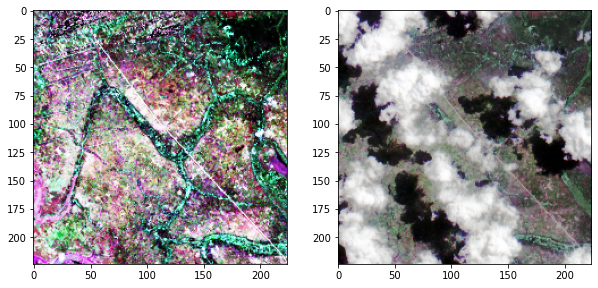

In [26]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

r = Recall()
p = Precision()
a = BinaryAccuracy()

true_and_true = 0
true_and_false = 0
false_and_false = 0
false_and_true = 0
total = 0 
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    
    yhat = siamese_model.predict([test_input, test_val])
    
    #yhat = [1 if (prediction < 0.5 and prediction > -0.5) else 0 for prediction in yhat]
    #temp = [1 if e > 0.5 else 0 for e in y_true]

    yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
    temp = [1 if e == 1.0 else 0 for e in y_true]

    for e, i in zip(yhat, temp):
      total += 1
      if e == 1 and i == 1:
        #true positive
        true_and_true += 1
      elif e == 1 and i == 0:
        #false positive
        true_and_false += 1
      elif e == 0 and i == 0:
        #true negative
        false_and_false += 1
      elif e == 0 and i == 1:
        #false negative
        false_and_true += 1

    r.update_state(temp,yhat)
    p.update_state(temp,yhat) 
    a.update_state(temp,yhat)

    print(temp)
    print(yhat)

print("------------------------------------------------")
print(true_and_true)
print(true_and_false)
print(false_and_false)
print(false_and_true)
print("------------------------------------------------")

acc = (true_and_true + false_and_false)/total
print(acc)

print(r.result().numpy(), p.result().numpy(), a.result().numpy())

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [23]:
# Save weights
siamese_model.save('/content/drive/MyDrive/Third_Year_Project/Siamese_Network/siamesemodelv2.h5')
L1Dist
# Reload model 
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/Third_Year_Project/Siamese_Network/siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[2.9229533e-03],
       [1.1233453e-04],
       [1.3782689e-01],
       [2.2137312e-04],
       [5.3489010e-04],
       [8.1068361e-01],
       [9.2716730e-01],
       [9.6825652e-02],
       [4.6092217e-05],
       [9.6003705e-01],
       [1.9533040e-04],
       [9.0489447e-01]], dtype=float32)

In [24]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4096)         134260544   ['input_img[0][0]',              
                                                                  'validation_img[0][

In [25]:
import h5py

filename = "/content/drive/MyDrive/Third_Year_Project/Siamese_Network/siamesemodelv2.h5"

h5 = h5py.File(filename,'r')

futures_data = h5  # VSTOXX futures data

print(h5)

h5.close()

<HDF5 file "siamesemodelv2.h5" (mode r)>
